In [1]:
#==========================#
# Import relevant packages #
#==========================#


import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfinv
from iminuit import Minuit
from scipy.stats import chi2
from scipy.stats import binom
%matplotlib inline
from scipy.stats import poisson

## Functions

In [2]:
#——————————————————————————————————————————————————————#
# Find maximum value of the distribution within limits #
#——————————————————————————————————————————————————————#

def find_max(func, low_limit, high_limit, grid=100000):
    x = np.linspace(low_limit, high_limit, num=grid, endpoint=True)
    y = func(x)
    return y.max()

In [3]:
#——————————————————————————————————————————————————#
# A function used to show result of minuit fitting #
#——————————————————————————————————————————————————#
def showIminuitResult(m, init_params, params_units):
    #averageList = {}
    valDict = m.values
    errDict = m.errors
    paramNames = list(init_params.keys())
    print('\nMinuit fit results are:')
    for i, pn in enumerate(paramNames):
        print(f'\t{paramNames[i]}: {valDict[pn]:.4g}\u00b1{errDict[pn]:.2g} {params_units[i]}')
    print('\n')

## Different individual PDF Classes

In [4]:
#==================================================================#
# Create an Gaussian class (used to model the signal distribution) #
#==================================================================#


class Gaussian(object):

    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, mean, sigma, loBound, highBound):
   
        self.loBound = loBound
        self.highBound = highBound
        self.mean = mean
        self.sigma = sigma

        #initialize an mass list used to store mass values
        self.mass = []
    
    
    #———————————————————————————————#
    # Evaluation method (normalize) #
    #———————————————————————————————#

    def evaluate(self, x):
        return (1/(self.sigma*np.sqrt(2.*np.pi))) * np.exp( -(x-self.mean)**2/(2.*self.sigma**2) )
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result
    
    
    #————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal #
    # method generated var is returned and appended to the mass list     #
    #————————————————————————————————————————————————————————————————————#

    def next(self):
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x
    

    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

In [5]:
#=========================================================================#
# Create an Exponential class (used to model the background distribution) #
#=========================================================================#


class Exponential(object):
    
    # Constructor
    def __init__(self, loBound, hiBound, decayConst):
        self.loBound = loBound
        self.hiBound = hiBound
        self.decayConst = decayConst
        self.max = find_max(self.evaluate, self.loBound, self.hiBound)
    
    # Set parameters
    def setParameters(self, decayConst):
        self.decayConst = decayConst
    
     # Returns max value of function
    def maxVal(self) :
        return self.max

    # Evaluate method (normalized)
    def evaluate(self, t):
        part1 = np.exp(-t/self.decayConst)
        norm1 = self.decayConst*(1-np.exp(-self.hiBound/self.decayConst))
        return part1/norm1 

In [6]:
#====================================================================================#
# Create a second order polynomial class (used to model the background distribution) #
#====================================================================================#

class SecondOrderPoly(object):
    # Constructor
    def __init__(self, loBound, hiBound, a, b, c):
        self.loBound = loBound
        self.hiBound = hiBound
        self.a = a
        self.b = b
        self.c = c

    def setParameters(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate_unnorm, loBound, highBound)
        return integral_result

    # calculating normalization factor
    def norm_factor(self):
    # Define normalization of the second order polynomial
        return self.integrate(self.loBound, self.hiBound)
  

    # Evaluate method (un-normalized)
    def evaluate_unnorm(self, x):
        return (self.a + self.b*x + self.c*(x**2))
    

    # Evaluate method (normalized)
    def evaluate(self, x):
        return (self.evaluate_unnorm(x)/self.norm_factor())

In [7]:
#===================================================================#
# Create a linear class (used to model the background distribution) #
#===================================================================#

class Linear(object):
    # Constructor
    def __init__(self, loBound, hiBound, a, b):
        self.loBound = loBound
        self.hiBound = hiBound
        self.a = a
        self.b = b

    def setParameters(self, a, b):
        self.a = a
        self.b = b

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate_unnorm, loBound, highBound)
        return integral_result
    
    # calculating normalization factor
    def norm_factor(self):
    # Define normalization of the second order polynomial
        return self.integrate(self.loBound, self.hiBound)
  

    # Evaluate method (un-normalized)
    def evaluate_unnorm(self, x):
        return (self.a + self.b*x)
    

    # Evaluate method (normalized)
    def evaluate(self, x):
        return (self.evaluate_unnorm(x)/self.norm_factor())

## Joint Background + Signal PDF Classes

In [8]:
#===========================================================================================#
# Create class that generate a function consisting a Gaussian signal and an exponential bkg #
#===========================================================================================#


class GausSignalWithExpBkg(object):

    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, loBound, hiBound, bkgFraction, mean, sigma, decayConst):
        self.bkgFraction = bkgFraction
        self.decayConst = decayConst
        self.loBound = loBound
        self.hiBound = hiBound

        # initialize pdf class to create gaussian signal and an exponential bkg
        self.signal = Gaussian(mean, sigma, self.loBound, self.hiBound)
        self.bkg = Exponential(self.loBound, self.hiBound, decayConst)


    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, bkgFraction, mean, sigma, decayConst):
        self.bkg.decayConst = decayConst
        self.bkgFraction  = bkgFraction
        self.signal.mean = mean
        self.signal.sigma = sigma


    #———————————————————#
    # Evaluation method #
    #———————————————————#

    def evaluate(self, x):
        return (1-self.bkgFraction)*self.signal.evaluate(x) + self.bkgFraction*self.bkg.evaluate(x)


    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result


In [9]:
#====================================================================================================#
# Create class that generate a function consisting a Gaussian signal and an 2nd order polynomial bkg #
#====================================================================================================#


class GausSignalWithSecondOrderPolyBkg(object):

    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, loBound, hiBound, bkgFraction, mean, sigma, a, b, c):
        self.bkgFraction = bkgFraction
        self.loBound = loBound
        self.hiBound = hiBound

        # initialize pdf class to create gaussian signal and an exponential bkg
        self.signal = Gaussian(mean, sigma, self.loBound, self.hiBound)
        self.bkg = SecondOrderPoly(self.loBound, self.hiBound, a, b, c)


    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, bkgFraction, mean, sigma, a, b, c):
        self.bkgFraction = bkgFraction
        self.signal.mean = mean
        self.signal.sigma = sigma
        self.bkg.a = a
        self.bkg.b = b
        self.bkg.c = c


    #———————————————————#
    # Evaluation method #
    #———————————————————#

    def evaluate(self, x):
        return (1-self.bkgFraction)*self.signal.evaluate(x) + self.bkgFraction*self.bkg.evaluate(x)
    
    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result

In [10]:
#======================================================================================#
# Create class that generate a function consisting a Gaussian signal and an linear bkg #
#======================================================================================#


class GausSignalWithLinearBkg(object):

    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, loBound, hiBound, bkgFraction, mean, sigma, a, b):
        self.bkgFraction = bkgFraction
        self.loBound = loBound
        self.hiBound = hiBound

        # initialize pdf class to create gaussian signal and an exponential bkg
        self.signal = Gaussian(mean, sigma, self.loBound, self.hiBound)
        self.bkg = Linear(self.loBound, self.hiBound, a, b)


    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, bkgFraction, mean, sigma, a, b):
        self.bkgFraction = bkgFraction
        self.signal.mean = mean
        self.signal.sigma = sigma
        self.bkg.a = a
        self.bkg.b = b


    #———————————————————#
    # Evaluation method #
    #———————————————————#

    def evaluate(self, x):
        return (1-self.bkgFraction)*self.signal.evaluate(x) + self.bkgFraction*self.bkg.evaluate(x)
    
    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result

## Optimizer Class (Negative Log-Likelihood)

In [11]:
#==========================================================================================#
# Create class for negative log-likelihood minimization statistic used for fitting the pdf #
#==========================================================================================#

class NegativeLLcalculator(object):
    
    def __init__(self, pdf, data):
        self.pdf = pdf
        self.data = data


    # function used to update data, mainly for the ability to recycle this class for different fit pdfs
    def updateData(self, data):
        self.data = data

    # Function used to calculate log likelihood
    def calc_neg_LL(self):
        likelihood = self.pdf.evaluate(self.data)/(self.pdf.integrate(self.pdf.loBound, self.pdf.hiBound))
        log_likelihood = np.log(likelihood)
        return -log_likelihood.sum()

    # To calcualte an NLL from a dataset and a Gaussian signal with exponential background pdf
    def evaluateGausSignalWithExpBkg(self, bkgFraction, mean, sigma, decayConst):
        nll = 0.
        self.pdf.setParameters(bkgFraction, mean, sigma, decayConst)
        # here, compute the log likelyhood
        return self.calc_neg_LL()
    
    # To calcualte an NLL from a dataset and a Gaussian signal with 2nd order polynomial background pdf
    def evaluateGausSignalWithSecondOrderPolyBkg(self, bkgFraction, mean, sigma, a, b, c):
        nll = 0.
        self.pdf.setParameters(bkgFraction, mean, sigma, a, b, c)
        # here, compute the log likelyhood
        return self.calc_neg_LL()
    
    # To calcualte an NLL from a dataset and a Gaussian signal with linear background pdf
    def evaluateGausSignalWithLinearBkg(self, bkgFraction, mean, sigma, a, b):
        nll = 0.
        self.pdf.setParameters(bkgFraction, mean, sigma, a, b)
        # here, compute the log likelyhood
        return self.calc_neg_LL()


### Initiate Dictionary for holding minimized mean (M) parameter value as well as its statistical errors for different models we have

In [12]:
optimized_mean_val = {}
mean_statErr = {}

## Code Execution (Checkpoint 6)

Begin by plotting the distribution from the data .txt file.

In [13]:
#============================#
# Load in the data .txt file #
#============================#

data_evts = np.loadtxt('datafile-higgs.txt')

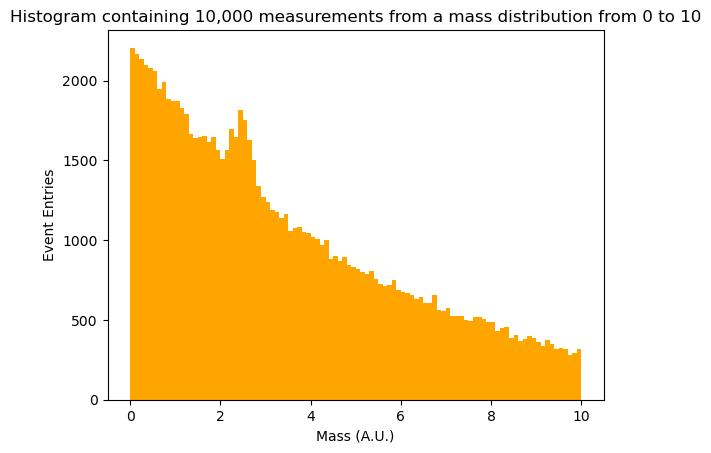

In [14]:
#===================#
# Define Parameters #
#===================#

loBound = 0.
hiBound = 10.
n_bins = 100


#===========================================#
# Plot the data distribution in a histogram #
#===========================================#

plt.hist(data_evts, n_bins, color='orange')
plt.title('Histogram containing 10,000 measurements from a mass distribution from 0 to 10')
plt.xlabel('Mass (A.U.)')
plt.ylabel('Event Entries')
plt.show()

### **Part I**

The data distribution above contains 10,000 measurements from a mass distribution.

The distribution is described by the following:
- A fraction $F=0.98$ of events from a background exponential  $\sim e^{-(\frac{m}{A})}$ where $A=5$.
- A fraction (signal fraction) $(1-F) =0.02$ of a signal Gaussian. 
- Gaussian mean $M = 2.5$ and width of $\sigma = 0.2$.
- There are only events in the range $[0,10]$.

With the above in mind, in the code below, we try to fit the data distribution with a signal gaussian and an exponential background by using Minuit. And determine the best fit parameters for A, F, and M, alongside with their statistical uncertainties.

In [15]:
def partI():

    # define the parameters
    loBound = 0.
    hiBound = 10.
    # Define fit parameters in a dictionary
    init_params = {
        'bkgFraction':              0.98,
        'mean':                     2.5,
        'sigma':                    0.2,
        'decayConst':               5.,   
    }


    # First initialize the pdf classes for function we use to fit, and the fitting statistics
    pdf = GausSignalWithExpBkg(loBound=loBound, hiBound=hiBound, **init_params)
    fit_stats = NegativeLLcalculator(pdf, data_evts)

    # Initialize iminuit minimizer
    minimizer = Minuit(fit_stats.evaluateGausSignalWithExpBkg, **init_params)
    minimizer.fixed['sigma'] = True

    # Set the error difference to 0.5 (we are using NegativeLL)
    minimizer.errordef = 0.5

    # Fit for best parameters
    mresult = minimizer.migrad()
    params_units = ['', '(A.U.)', '(A.U.)', '']
    showIminuitResult(minimizer, init_params, params_units)

    # save the optimized mean val and stat err for calculation of systematic err 
    optimized_mean_val['gausSignalWithExpBkg'] = mresult.values['mean']
    mean_statErr['gausSignalWithExpBkg'] = mresult.errors['mean']

    # Now plot the distribution of data alongside with our fit
    x_vals = np.linspace(loBound, hiBound, n_bins, endpoint=True)
    plt.hist(data_evts, n_bins, color='orange', label='Data', density=True)
    plt.plot(x_vals, (pdf.evaluate(x_vals)/pdf.integrate(loBound, hiBound)), color='blue', label='Fit')
    plt.xlabel('Mass (A.U.)')
    plt.ylabel('Probability')
    plt.legend()
    plt.title('Histogram containing 10,000 measurements from a mass distribution from 0 to 10')



Minuit fit results are:
	bkgFraction: 0.9796±0.0012 
	mean: 2.499±0.015 (A.U.)
	sigma: 0.2±0.002 (A.U.)
	decayConst: 5.008±0.031 




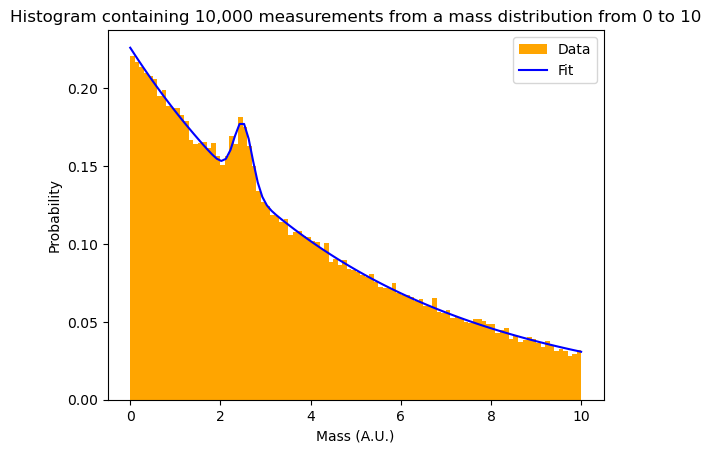

In [16]:
partI()

### **Part II**

Now, fit to the same data using the same Gaussian signal model but now using a 2nd order polynomial background model. Similarly as before, by using Minuit minimizer. Then the fitted parameters will be presented all together. With the fitted Gaussian mean being presented with (systematic and statistical error), and presented with a total error. 

The importance of the systematic error compared to the statistical error for the measurement of mean will be explained as well at the end of this part.

The fit pdf is described with a Gaussian signal and a 2nd order polynomial bkg, with the background model described as:
$$
f_{bkg}(x) = a+bx+cx^2
$$
And the parameters are:
* Background Fraction F = 0.98
* Mean (M) = 2.5
* Sigma $\sigma$ = 0.2
* a = 1
* $\frac{b}{a}$ = -0.16
* $\frac{c}{a}$ = 0.007

In [17]:
def partII():
    # define the parameters
    loBound = 0.
    hiBound = 10.
    # Define fit parameters in a dictionary
    init_params = {
        'bkgFraction':              0.98,
        'mean':                     2.5,
        'sigma':                    0.2,
        'a':                        1., 
        'b':                        -0.16,
        'c':                        0.007,
    }

    # First initialize the pdf classes for function we use to fit, and the fitting statistics
    pdf = GausSignalWithSecondOrderPolyBkg(loBound=loBound, hiBound=hiBound, **init_params)
    fit_stats = NegativeLLcalculator(pdf, data_evts)

    # Initialize iminuit minimizer
    minimizer = Minuit(fit_stats.evaluateGausSignalWithSecondOrderPolyBkg, **init_params)
    minimizer.fixed['a'] = True

    # Set the error difference to 0.5 (we are using NegativeLL)
    minimizer.errordef = 0.5

    #Fit for best parameters
    mresult = minimizer.migrad()
    params_units = ['', '(A.U.)', '(A.U.)', '', '(A.U.)','(A.U.^2)']
    showIminuitResult(minimizer, init_params, params_units)

    # save the optimized mean val and stat err for calculation of systematic err 
    optimized_mean_val['gausSignalWithSecondOrderPolyBkg'] = mresult.values['mean']
    mean_statErr['gausSignalWithSecondOrderPolyBkg'] = mresult.errors['mean']

    # Now plot the distribution of data alongside with our fit
    x_vals = np.linspace(loBound, hiBound, n_bins, endpoint=True)
    plt.hist(data_evts, n_bins, color='orange', label='Data', density=True)
    plt.plot(x_vals, (pdf.evaluate(x_vals)/pdf.integrate(loBound, hiBound)), color='blue', label='Fit')
    plt.xlabel('Mass (A.U.)')
    plt.ylabel('Probability')
    plt.legend()
    plt.title('Histogram containing 10,000 measurements from a mass distribution from 0 to 10')

    # Now, compute the systematic error and the total error on the gaussian mean (M) parameter.
    mean_sysErr = abs(optimized_mean_val['gausSignalWithExpBkg'] - optimized_mean_val['gausSignalWithSecondOrderPolyBkg'])
    mean_totErr = np.sqrt(mean_statErr['gausSignalWithExpBkg']**2 + mean_sysErr**2)
    print('The fitted/optimized value for the parameter mean (M) in the format of = V \u00b1 E_stat \u00b1 E_sys is: ' + \
          '%.4g \u00b1 %.2g \u00b1 %.2g (A.U.)' % (mresult.values['mean'], mresult.errors['mean'], mean_sysErr))
    print('The fitted/optimized value for the parameter mean (M) in the format of = V \u00b1 E_tot is: ' + \
          '%.4g \u00b1 %.2g (A.U.)' % (mresult.values['mean'], mean_totErr))

    


Minuit fit results are:
	bkgFraction: 0.9832±0.0013 
	mean: 2.498±0.015 (A.U.)
	sigma: 0.175±0.013 (A.U.)
	a: 1±0.01 
	b: -0.1578±0.0011 (A.U.)
	c: 0.007297±0.00012 (A.U.^2)


The fitted/optimized value for the parameter mean (M) in the format of = V ± E_stat ± E_sys is: 2.498 ± 0.015 ± 7.1e-05 (A.U.)
The fitted/optimized value for the parameter mean (M) in the format of = V ± E_tot is: 2.498 ± 0.015 (A.U.)


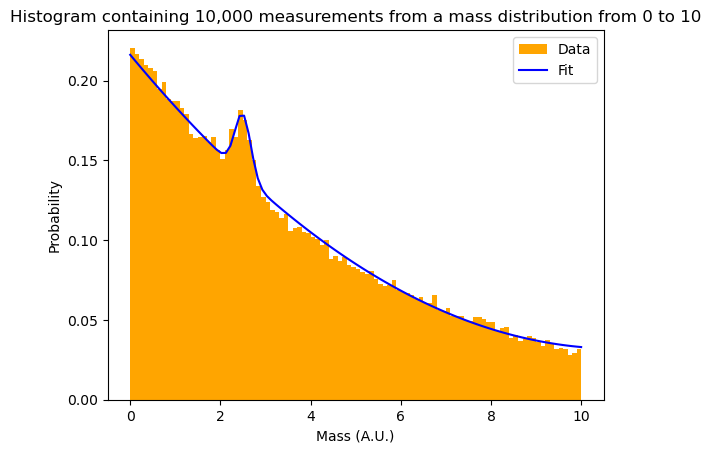

In [18]:
partII()

In general systematic error comes from "lack of knowledge", and is an additional error quantity that we add up behind the statistical error. In our case in this cp, the error that this "lack of knowledge" introduced can be quantified by re-doing the fit with different background models. And specifically we are interested in how the gaussian mean parameter changes under the different background model, while the signal model stays as Gaussian. 

Now with the fit redone using second order polynomial background model, we take the difference of the best fit mean values from the two models as some gauge of our systematic error due to the background fit model. Comparing to statistical error, the systematic error is different and it is very important as it gives us an idea of the relative accuracy between the models (the small) while the statistical error gives us the precision of the model (the larger the statistical error, the less precise a model is). In the two cases here, we can see that we have quite a small systematic error, showing that relative to the exponential, the second order polynomial background model have a pretty good accuracy, but the precision on the second polynomial model is not as good as the exponential model.

### **Part III**

Now, fit to the same data using the same Gaussian signal model but now using a linear line background model. Similarly as before, by using Minuit minimizer. Then the fitted parameters will be presented all together. With the fitted Gaussian mean being presented with (systematic and statistical error), and presented with a total error. 

The importance of the systematic error compared to the statistical error for the measurement of mean will be explained as well at the end of this part.

The fit pdf is described with a Gaussian signal and a linear line background, with the background model described as:
$$
f_{bkg}(x) = a+bx
$$
And the parameters are:
* Background Fraction F = 0.98
* Mean (M) = 2.5
* Sigma $\sigma$ = 0.2
* a = 1
* $\frac{b}{a}$ = -0.09

In [19]:
def partIII():
    # define the parameters
    loBound = 0.
    hiBound = 10.
    # Define fit parameters in a dictionary
    init_params = {
        'bkgFraction':              0.98,
        'mean':                     2.5,
        'sigma':                    0.2,
        'a':                        1., 
        'b':                        -0.09,
    }

    # First initialize the pdf classes for function we use to fit, and the fitting statistics
    pdf = GausSignalWithLinearBkg(loBound=loBound, hiBound=hiBound, **init_params)
    fit_stats = NegativeLLcalculator(pdf, data_evts)

    # Initialize iminuit minimizer
    minimizer = Minuit(fit_stats.evaluateGausSignalWithLinearBkg, **init_params)
    minimizer.fixed['a'] = True

    # Set the error difference to 0.5 (we are using NegativeLL)
    minimizer.errordef = 0.5

    #Fit for best parameters
    mresult = minimizer.migrad()
    params_units = ['', '(A.U.)', '(A.U.)', '', '(A.U.)']
    showIminuitResult(minimizer, init_params, params_units)

    # save the optimized mean val and stat err for calculation of systematic err 
    optimized_mean_val['gausSignalWithLinearBkg'] = mresult.values['mean']
    mean_statErr['gausSignalWithLinearBkg'] = mresult.errors['mean']

    # Now plot the distribution of data alongside with our fit
    x_vals = np.linspace(loBound, hiBound, n_bins, endpoint=True)
    plt.hist(data_evts, n_bins, color='orange', label='Data', density=True)
    plt.plot(x_vals, (pdf.evaluate(x_vals)/pdf.integrate(loBound, hiBound)), color='blue', label='Fit')
    plt.xlabel('Mass (A.U.)')
    plt.ylabel('Probability')
    plt.legend()
    plt.title('Histogram containing 10,000 measurements from a mass distribution from 0 to 10')

    # Now, compute the systematic error and the total error on the gaussian mean (M) parameter.
    mean_sysErr = abs(optimized_mean_val['gausSignalWithExpBkg'] - optimized_mean_val['gausSignalWithLinearBkg'])
    mean_totErr = np.sqrt(mean_statErr['gausSignalWithExpBkg']**2 + mean_sysErr**2)
    print('The fitted/optimized value for the parameter mean (M) in the format of = V \u00b1 E_stat \u00b1 E_sys is: ' + \
          '%.4g \u00b1 %.2g \u00b1 %.2g (A.U.)' % (mresult.values['mean'], mresult.errors['mean'], mean_sysErr))
    print('The fitted/optimized value for the parameter mean (M) in the format of = V \u00b1 E_tot is: ' + \
          '%.4g \u00b1 %.2g (A.U.)' % (mresult.values['mean'], mean_totErr))


Minuit fit results are:
	bkgFraction: 0.9801±0.0014 
	mean: 2.465±0.016 (A.U.)
	sigma: 0.1999±0.016 (A.U.)
	a: 1±0.01 
	b: -0.0904±0.00022 (A.U.)


The fitted/optimized value for the parameter mean (M) in the format of = V ± E_stat ± E_sys is: 2.465 ± 0.016 ± 0.033 (A.U.)
The fitted/optimized value for the parameter mean (M) in the format of = V ± E_tot is: 2.465 ± 0.036 (A.U.)


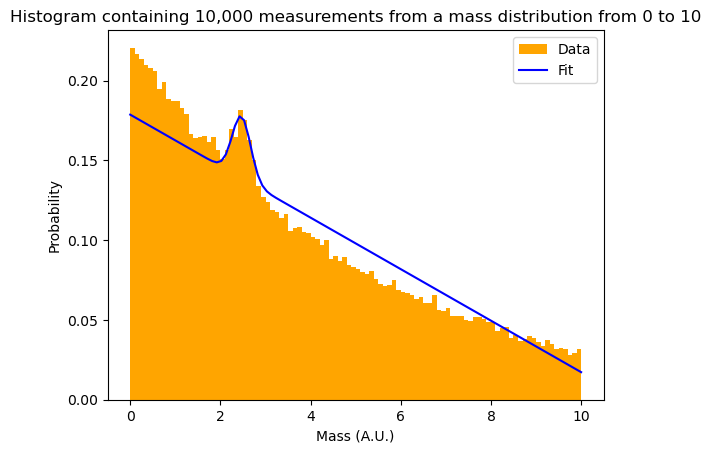

In [20]:
partIII()

Now with the fit redone using linear background model, by looking at the statistical error, we can see that precision-wise out of the three background models, the linear is the least precise model, and exponential is the most precise model. And the largest best fit parameter (mean M) value difference comes from the linear background model and the exponential background model, so out of the three models, that is what we will take as our systematic error. As a summary after we do the fit with 3 different background model accuracy and precision wise:

* Exponential background model with Gaussian signal appears to be the most accurate and the most precise fit model.
* Second order polynomial background model with Gaussian signal appears to be very accurate but not as precise as the exponential.
* The linear background model with Gaussian signal appears have some accuracy but the least precise out of the three models.